In [1]:
# Imports
import pandas as pd
import numpy as np
import pickle
from datetime import datetime
from shapely import geometry
import matplotlib.pyplot as plt
import geopandas
import shapely.wkt

pd.options.display.max_colwidth = 2000000

In [2]:
# Read FIR Codes
df = pd.read_csv('data/NA_FIR_Codes.csv')

# Read Vertices
df2 = pd.read_csv('data/vertices_20220621.csv')

# Read Spaceports
df3 = pd.read_csv ('data/spaceports_20201027.csv')

# Read pickle file with topics and augmented text
df4 = pd.read_pickle("data/allData.pkl")

# Read Polygon File
df5 = pd.read_csv('data/polygon_20201027.csv')

# Airport Codes
df6 = pd.read_csv('data/airports.csv', keep_default_na=False)

# ARTCC
#df7 = pd.read_csv ('data/faa_artcc_polygons.csv')

# Read Basemap Shapefile
states = geopandas.read_file('data/bound_p.shx')

In [3]:
# One off testing and tuning

#time = '10/05/2017  08:00:00 AM' #349
#time = '2/20/2016  7:40:00 PM' #230
#time = '4/22/2020  7:30:30 PM' #514
#time = '11/16/2017  2:52:00 AM' #364
#time = '12/5/2018  6:16:16 PM' #438
#time = '10/17/2018  4:15:00 AM' #431 has JAXA launch in it as well (t=6)
#time = '9/24/2017  5:49:47 AM' #347
#time = '8/6/2019  11:23:00 PM' #475 has a russian launch as well (t=6)
#time = '3/26/2020  8:18:00 PM' #512
#time = '3/18/2017  11:44:00 PM' #305
#time = '8/16/2016  11:31:00 PM' #262
time = '5/26/2016  9:40:00 PM' #248
#time = '2/22/2018  2:17:00 PM' #385
#time = '3/2/2019  12:00:00 AM' #450
#time = '11/11/2016  6:30:33 PM' #275
#time = '10/30/2017  7:34:00 PM' #358
#time = '10/30/2017  12:57:00 AM' #357
#time = '1/27/2020  1:40:00 AM' #504
#time = '2/14/2017  12:00:00 PM' #293
#time = '2/15/2017  12:00:00 PM' #294
#time = '12/12/2017  12:00:00 AM' # 368
#time = '4/7/2020  12:00:00 AM' #513
#time = '5/6/2016  5:21:00 AM' #243
#time = '4/2/2018  8:30:38 PM' #391

date_time_obj = datetime.strptime(time, '%m/%d/%Y %H:%M:%S %p')

In [4]:
# Date filter
filterA = df4[(df4['POSSIBLE_START_DATE'] <= time) & (df4['POSSIBLE_END_DATE'] >= time)]

In [5]:
# Altitude filter
filterB = filterA[filterA['MAX_ALT'] >= 50 | filterA['MAX_ALT'].isna()]

In [6]:
# FIR Code filter
filterC = filterB[filterB['LOCATION_CODE'].isin(df['FIR']) | filterB['LOCATION_CODE'].isna()]

# US Airport Code filter
#filterC = filterB[filterB['LOCATION_CODE'].isin(df['FIR']) | filterB['LOCATION_CODE'].isna() | filterB['LOCATION_CODE'].isin(df2['locid'])]

In [7]:
# Keyword filter
filterD = filterC[(filterC['TEXT'].str.contains(r'(?:\s|^)rocket(?:\s|$)') == True) | 
                      (filterC['TEXT'].str.contains(r'(?:\s|^)space(?:\s|$)') == True) |
                      (filterC['TEXT'].str.contains(r'(?:\s|^)launch(?:\s|$)') == True) |
                      (filterC['TEXT'].str.contains(r'(?:\s|^)missile(?:\s|$)') == True) |
                      (filterC['TEXT'].str.contains(r'(?:\s|^)canaveral(?:\s|$)') == True) |
                      (filterC['TEXT'].str.contains(r'(?:\s|^)kennedy(?:\s|$)') == True) |
                      (filterC['TEXT'].str.contains(r'(?:\s|^)nasa(?:\s|$)') == True) |
                      (filterC['TEXT'].str.contains(r'(?:\s|^)unlimited(?:\s|$)') == True)]

In [8]:
# Topic filter
filterE = filterD[(filterD['TOPIC'] == 0) | (filterD['TOPIC'] == 7)]

In [9]:
# Print out
filterE[['TOPIC','XGB', 'NOTAM_REC_ID', 'LOCATION_CODE', 'TEXT']]

TOPIC  XGB  NOTAM_REC_ID LOCATION_CODE  \
1005      7    1          1006           ZMA   
1075      7    1          1076           ZMA   
1120      7    0          1121           ZWY   
1139      7    1          1140           ZMA   
1154      7    1          1155           ZWY   
6131      0    1          6132           ZMA   
6132      0    1          6133           ZMA   
7530      0    1          7531           ZAB   
7531      0    1          7532           ZAB   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [10]:
# Creates WKT Polygons
def getPolygons(id_list):
    all_polys = {}

    for poly_id in id_list:
        tmp = df2[df2['POLYGON_ID'] == poly_id]

        long = tmp['LONGITUDE'].astype(str).values
        lat = tmp['LATITUDE'].astype(str).values

        pointList = list(zip(tmp['LONGITUDE'], tmp['LATITUDE']))

        if len(pointList) == 1:
            poly = geometry.Point([pointList[0][0], pointList[0][1]])
        elif len(pointList) == 2:
            poly = geometry.LineString([[p[0], p[1]] for p in pointList])
        else:
            poly = geometry.Polygon([[p[0], p[1]] for p in pointList])

        all_polys[poly_id] = poly
        
    return all_polys

# Gets Poylgon ID from NOTAM ID
def getIds(rec_ids, poly_df):
    id_list = []
    for row in rec_ids['NOTAM_REC_ID']:
        for item in poly_df[poly_df['NOTAM_REC_ID'] == row]['POLYGON_ID'].values:
            id_list.append(item)
            
    return id_list

In [11]:
# Get IDs for Candidate NOTAMs
id_list = getIds(filterE, df5)

# Get Polygons for Candidate NOTAMs
P = getPolygons(id_list)

Text(0.5, 1.0, 'NOTAM Geometries')

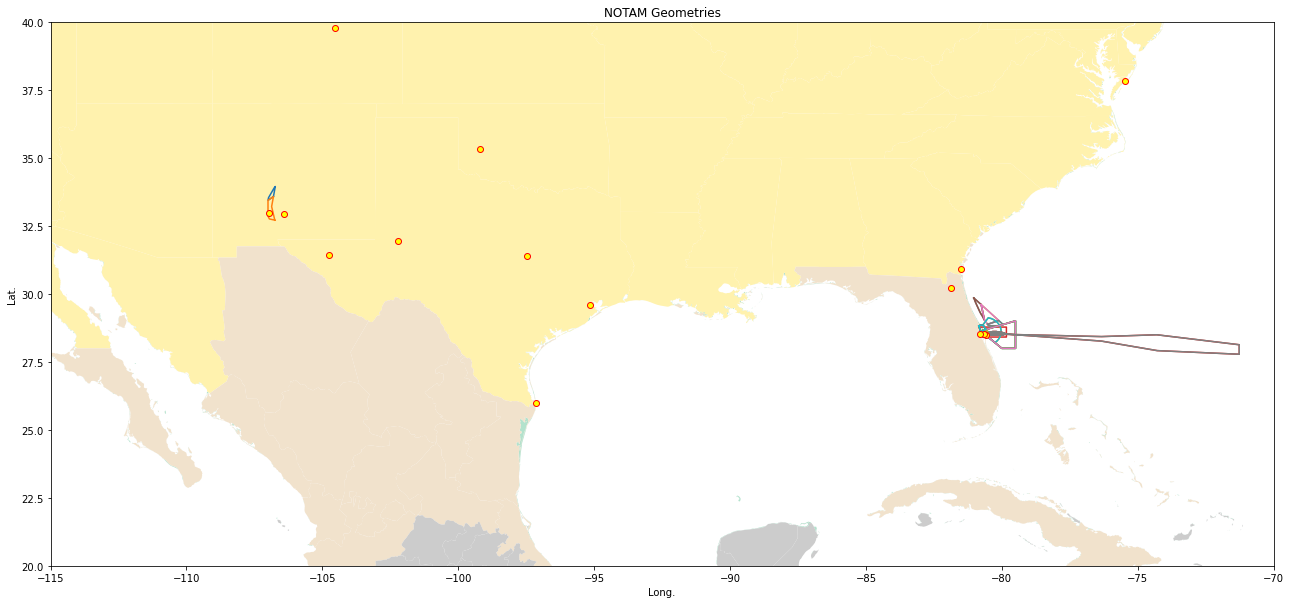

In [12]:
# Plot Base Map
states.plot(cmap='Pastel2', figsize=(30, 10))

# Plot NOTAM Polygons
for item in P.values():
    #if P:
     #   continue
    if item.geom_type != 'Polygon':
        plt.plot(*item.xy)
    else:
        x,y = item.exterior.xy
        plt.plot(x,y)

# ARTCC
#P2 = [shapely.wkt.loads(h) for h in df7['boundary']]
#
#for item in P2:
#    x,y = item.exterior.xy
#    plt.plot(x,y, linestyle="dashdot")
        
# Plot Spaceport Locations
plt.plot(df3['LONGITUDE'], df3['LATITUDE'], marker="o", markeredgecolor="red", markerfacecolor="yellow", linestyle="None")

# Set Zoom
#plt.axis([-83, -78, 27, 30])
plt.axis([-115, -70, 20, 40])
#plt.axis([-83, -75, 27, 33])
plt.ylabel('Lat.')
plt.xlabel('Long.')
plt.title('NOTAM Geometries')